In [30]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import seaborn as sns
import pandas as pd
import sys
from scipy.ndimage.filters import uniform_filter1d
sys.path.append('..')
import neatplot
neatplot.set_style()
neatplot.update_rc('font.size', 20)
matplotlib.rcParams['text.usetex'] = True
%matplotlib inline

In [4]:
# sns.set_theme()

In [5]:
base_path = Path('../experiments')
baseline_path = Path('../../bac-baselines/experiments')
process_seeds = True

In [40]:
env_name = 'Plasma Tracking'

In [41]:
beta_tracking_paths = {
    'TIP-10': 'rollout_beta_tracking_ph10_2022-04-18/19-20-54/',
    'TIP-2': 'rollout_beta_tracking_ph2_2022-04-17/11-49-30/seed_0/',
    'TIP-8': 'rollout_beta_tracking_ph8_2022-04-18/16-04-14/',
    'TIP-6': 'rollout_beta_tracking_ph6_2022-04-18/12-48-14/',
    'TIP-4': 'rollout_beta_tracking_ph4_2022-04-18/09-41-32/',
    # 'rollout barl 10000': 'rollout_barl_bt_10000_2022-03-25/15-46-28/',
}

In [77]:
plasma_tracking_paths_barl = {
        200: 'barl_pt_200_2022-04-07/10-07-17/',
        800: 'barl_pt_800_2022-04-07/16-58-46/',
        3200: 'barl_pt_3200_2022-04-08/00-38-21/',
        10000: 'barl_pt_10000_2022-04-08/00-41-11/',
}
plasma_tracking_paths_rollout_barl ={
        200: 'rollout_barl_pt_200_2022-03-20/22-49-51/',
        
}
plasma_tracking_paths = {'Pointwise': plasma_tracking_paths_barl,
                         'Rollout': plasma_tracking_paths_rollout_barl}
plasma_tracking_paths = {
        'barl 200': 'barl_pt_200_2022-04-07/10-07-17/',
        'barl 800': 'barl_pt_800_2022-04-07/16-58-46/',
        'barl 3200': 'barl_pt_3200_2022-04-13/09-55-48/',
        'barl 10k': 'barl_pt_10000_2022-04-13/20-39-06/',
        # 'barl 3200': 'barl_pt_3200_2022-04-08/00-38-21/',
        # 'barl 10000 (2)': 'barl_bt_10k_2022-03-20/21-35-18/',
        # 'barl 10000': 'barl_pt_10000_2022-04-08/00-41-11/',
        # 'rollout barl 200': 'rollout_barl_pt_200_2022-03-20/22-49-51/',
        # 'rollout barl 800': 'rollout_barl_pt_800_2022-03-22/09-13-42/',
        # 'rollout barl 10000': 'rollout_barl_pt_10000_2022-03-22/09-13-59/',
        'Rollout BARL': 'rollout_barl_plasma_tracking_2022-02-21/16-58-08/',
        'Rollout BARl (2)': 'rollout_barl_plasma_tracking_2022-03-22/09-51-58/',
        'TIP-2': 'rollout_plasma_tracking_ph2_2022-04-17/11-55-35/',
        'TIP-4': 'rollout_plasma_tracking_ph4_2022-04-18/09-38-00/'
}


In [78]:
cartpole_paths = {
        'Horizon 1': 'rollout_cartpole_ph1_2022-04-01/15-30-45/',
        'Horizon 2': 'rollout_cartpole_ph2_2022-04-01/19-57-38/',
        'Horizon 4': 'rollout_cartpole_ph4_2022-04-02/00-25-47/',
        'Horizon 8': 'rollout_cartpole_ph8_2022-04-02/04-49-55/',
        'Horizon 16': 'rollout_cartpole_ph16_2022-04-02/09-19-27/',
}

In [79]:
all_paths = {"Cartpole": cartpole_paths,
             # "Pendulum": pend_paths,
             # "Reacher": reacher_paths, 
             # 'Lava Path': lava_paths, 
             # "Reacher (tight)": reacher_tight_paths,
             "Beta Tracking": beta_tracking_paths,
             # "Beta Tracking Fixed": beta_tracking_fixed_paths,
             # 'Swimmer': swimmer_paths,
             'Plasma Tracking': plasma_tracking_paths,
             # 'Weird Gain': weird_gain_paths,
            }
paths = all_paths[env_name]
gt = {"Pendulum": -200,
      "Cartpole": -13,
      "Reacher": -5,
      'Lava Path': -30,
      'Reacher (tight)': -8.78,
      'Swimmer': 30,
      'Beta Tracking': -2.5,
      'Beta Tracking Fixed': -2.,
      'Plasma Tracking': -5,
      'Weird Gain': -110,
     }
ylim_bottom = {
        "Pendulum": -1500,
        "Cartpole": -25,
        "Reacher": -20,
        "Lava Path": -3000,
        "Beta Tracking": -12,
        "Plasma Tracking": -40,
        "Swimmer": -30,
        "Beta Tracking Fixed": -20,
        "Weird Gain": -200,
}
gt_val = gt[env_name]
bottom_val = ylim_bottom[env_name]

In [80]:
def process_bac(data):
    returns = np.vstack(data['Eval Returns'])

    data['Eval Mean Returns'] = returns.mean(axis=1)
    data['Eval Std Returns'] = returns.std(axis=1)#  / np.sqrt(returns.shape[1])
    return data


def process_bac_seeds(path):
    data = {}
    returns = []
    for i in range(5):
        seed_path = path / f"seed_{i}" / "info.pkl"
        if not seed_path.exists():
            continue
        with seed_path.open('rb') as f:
            seed_data = pickle.load(f)
        seed_returns = np.vstack(seed_data['Eval Returns'])
        returns.append(seed_returns.mean(axis=1))
        if i == 0:
            data['Eval ndata'] = seed_data['Eval ndata']
    max_return_length = max([len(ret) for ret in returns])
    returns = [ret for ret in returns if len(ret) == max_return_length]
    returns = np.vstack(returns)
    n_trials = returns.shape[0]
    print(n_trials)
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(n_trials)
    data['Eval Seed Returns'] = returns
    return data
            

def process_baseline(data):
    out = {}
    out['Eval Mean Returns'] = data["evaluation/Returns Mean"]
    out['Eval ndata'] = data['exploration/num steps total']
    out['Eval Std Returns'] = data['evaluation/Returns Std']
    return out


def process_baseline_seeds(path):
    if (path / f"seed_0" / "info.pkl").exists():
        return process_bac_seeds(path)
    data = {}
    returns = []
    for i in range(5):
        seed_path = path / f"seed_{i}" / "progress.csv"
        if not seed_path.exists():
            continue
        data_res = pd.read_csv(seed_path)
        returns.append(data_res["evaluation/Returns Mean"])
        if i == 0:
            data['Eval ndata'] = data_res['exploration/num steps total']
    max_return_length = max([len(ret) for ret in returns])
    returns = [ret for ret in returns if len(ret) == max_return_length]
    if len(returns) == 0:
        return {}
    returns = np.vstack(returns)
    
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(returns.shape[0])
    data['Eval Seed Returns'] = returns
    return data

In [81]:
data = {}
for key, path in paths.items():
    print(key)
    info_path = base_path / path / 'info.pkl'
    if info_path.exists():
        with info_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    info_seed_path = base_path / path / 'seed_0'
    if info_seed_path.exists():
        if process_seeds:
            data[key] = process_bac_seeds(base_path / path)
        else:
            info_path = info_seed_path / 'info.pkl'
            with info_path.open('rb') as f:
                data[key] = process_bac(pickle.load(f))
        print(f'found seed data for {key}')
        continue
    baseline_exp_path = baseline_path / path / 'progress.csv'
    if baseline_exp_path.exists():
        data_res = pd.read_csv(baseline_exp_path)
        reformatted_data = process_baseline(data_res)
        data[key] = reformatted_data
        continue
    baseline_pkl_path = baseline_path / path / 'info.pkl'
    if baseline_pkl_path.exists():
        with baseline_pkl_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    baseline_seed_path = baseline_path / path /'seed_0'
    if baseline_seed_path.exists():
        if True:
            val = process_baseline_seeds(baseline_path / path)
            if len(val) == 0:
                continue
            data[key] = val
        else:
            data[key] = process_baseline(baseline_seed_path)
        print(f"found seed data for {key}")
        continue
    print(f"Data for {key} not found!")

barl 200
5
found seed data for barl 200
barl 800
5
found seed data for barl 800
barl 3200
5
found seed data for barl 3200
barl 10k
5
found seed data for barl 10k
Rollout BARL
Rollout BARl (2)
5
found seed data for Rollout BARl (2)
TIP-2
5
found seed data for TIP-2
TIP-4
5
found seed data for TIP-4


In [82]:
smooth_curves = True

In [83]:
def smooth_data(data, window=5):
    data['Eval Mean Returns'] = uniform_filter1d(data['Eval Mean Returns'], size=window)
    data['Eval Std Returns'] = uniform_filter1d(data['Eval Std Returns'], size=window)
    return data

In [84]:
if smooth_curves:
    new_data = {}
    for k, v in data.items():
        new_data[k] = smooth_data(v)
    data = new_data

Text(0.5, 0.98, 'Control Performance on Plasma Tracking')

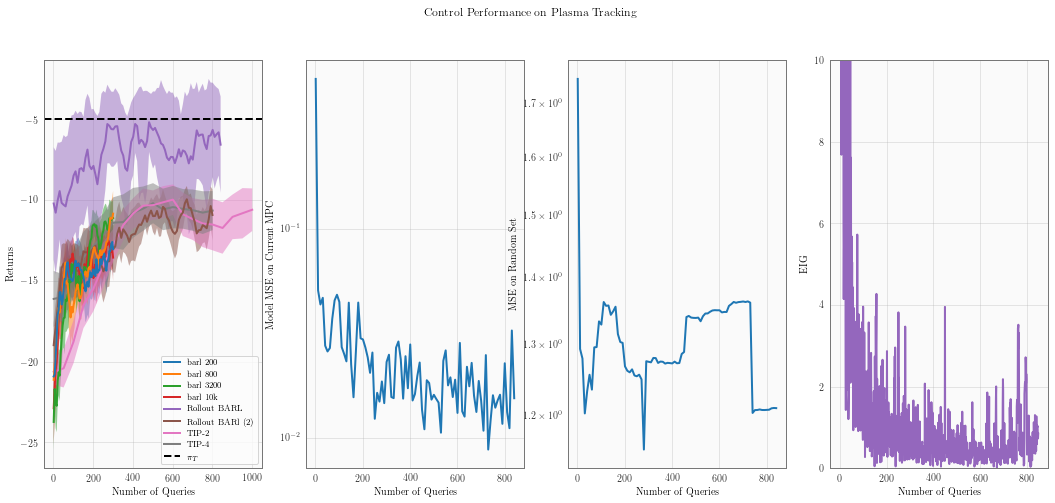

In [85]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(18, 7.5))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax1.plot(ndata, rmean, label=key, zorder=100 - i)
    ax1.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
        ax2.plot(ndata, mses, label=key)
    elif 'Model MSE (current MPC)' in vals:
        mses = vals['Model MSE (current MPC)']
        ax2.plot(ndata, mses, label=key)
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax3.plot(ndata, mses, label=key)
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        ax4.plot(acqs, label=key)
    else:
        ax4.plot([], label=key)

        
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Returns')
ax1.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax1.legend()
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Model MSE on Current MPC')
ax3.set_ylabel("MSE on Random Set")
ax3.set_xlabel('Number of Queries')
ax4.set_xlabel('Number of Queries')
ax4.set_ylabel('EIG')
if env_name == 'Lava Path':
    ax1.set_ylim(-1000, 0)
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_ylim(0, 10)
# ax1.set_xscale('log')

fig.suptitle(f"Control Performance on {env_name}")


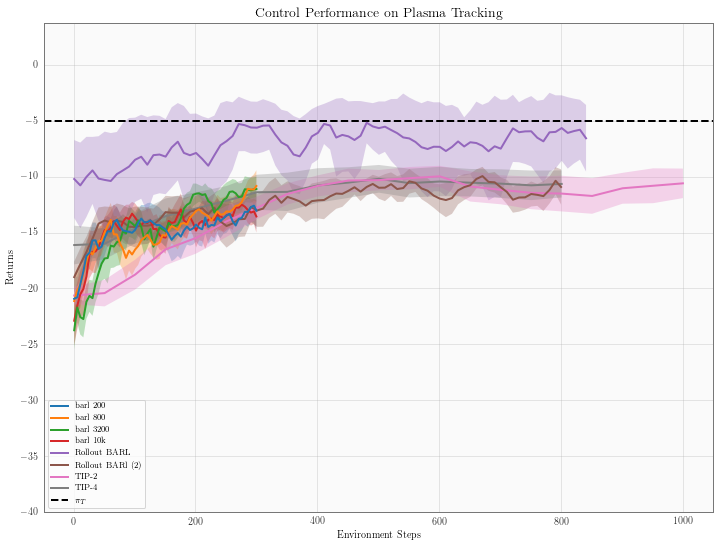

In [86]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key, zorder=100 - i)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax.legend()
ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
ax.set_ylim(bottom_val, ylim_top)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 500)
# ax.set_ylim(-10000, 0)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})
# fig.suptitle()
plt.savefig(f'sample_complexity_{env_name}.pdf') #, bbox_inches='tight')

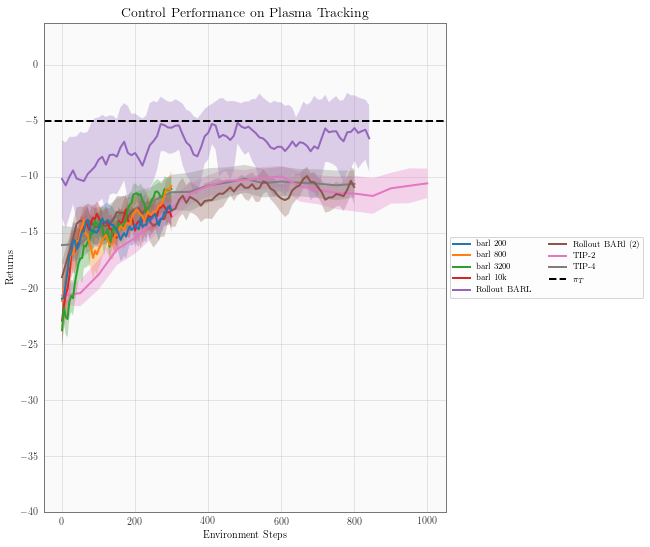

In [87]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key, zorder=100 - i)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
# ax.legend()
ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
ax.set_ylim(bottom_val, ylim_top)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 500)
# ax.set_ylim(-10000, 0)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fancybox=True)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})
# fig.suptitle()
plt.savefig(f'legend_{env_name}.pdf') #, bbox_inches='tight')

In [88]:
print(f"Sample complexity of algorithms on {env_name}")
sample_complexities = {}
for key, vals in data.items():
    if 'Eval Seed Returns' in vals:
        samps = []
        for row in vals['Eval Seed Returns']:
            try:
                sample_idx = np.where(row > gt_val)[0].min()
                samps.append(vals['Eval ndata'][sample_idx])
            except ValueError:
                samps.append(np.inf)
        print(f"{key}: {sorted(samps)}")
        continue
    rmean = vals["Eval Mean Returns"]
    try:
        sample_idx = np.where(rmean > gt_val)[0].min()
        sample_complexity = vals['Eval ndata'][sample_idx]
    except ValueError:
        sample_complexity = None
    sample_complexities[key] = sample_complexity
    print(f"{key}: {sample_complexity}")

Sample complexity of algorithms on Plasma Tracking
barl 200: [inf, inf, inf, inf, inf]
barl 800: [inf, inf, inf, inf, inf]
barl 3200: [inf, inf, inf, inf, inf]
barl 10k: [inf, inf, inf, inf, inf]
Rollout BARL: None
Rollout BARl (2): [inf, inf, inf, inf, inf]
TIP-2: [inf, inf, inf, inf, inf]
TIP-4: [inf, inf, inf, inf, inf]
